In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from confidence_interval import (
    compare_model_accuracies,
    logo_cv_confidence_interval,
)

model_names = [
    "Simple1d",
    "Simple1dEmbedding",
    "Simple2d",
    "Simple2dEmbedding",
    "ResNet50",
    "ResNet50Embedding",
]
target_features = ["endianness", "instructionwidth_type"]

Simple1d: 0.995 ± 0.001
Simple1dEmbedding: 0.999 ± 0.000
Simple2d: 0.995 ± 0.001
Simple2dEmbedding: 1.000 ± 0.000
ResNet50: 0.992 ± 0.001
ResNet50Embedding: 0.999 ± 0.000
Simple1d: 0.993 ± 0.001
Simple1dEmbedding: 0.999 ± 0.000
Simple2d: 0.995 ± 0.001
Simple2dEmbedding: 0.999 ± 0.000
ResNet50: 0.991 ± 0.001
ResNet50Embedding: 0.998 ± 0.000


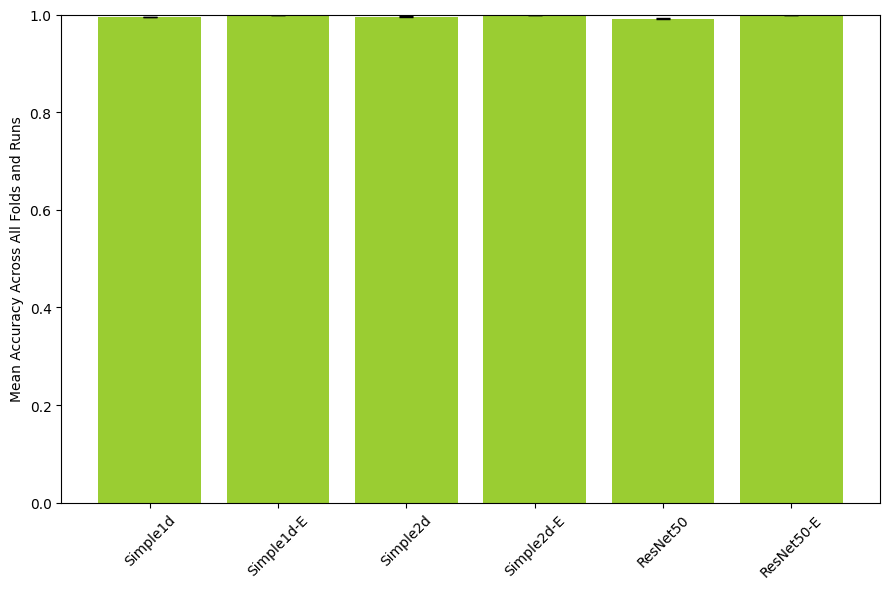

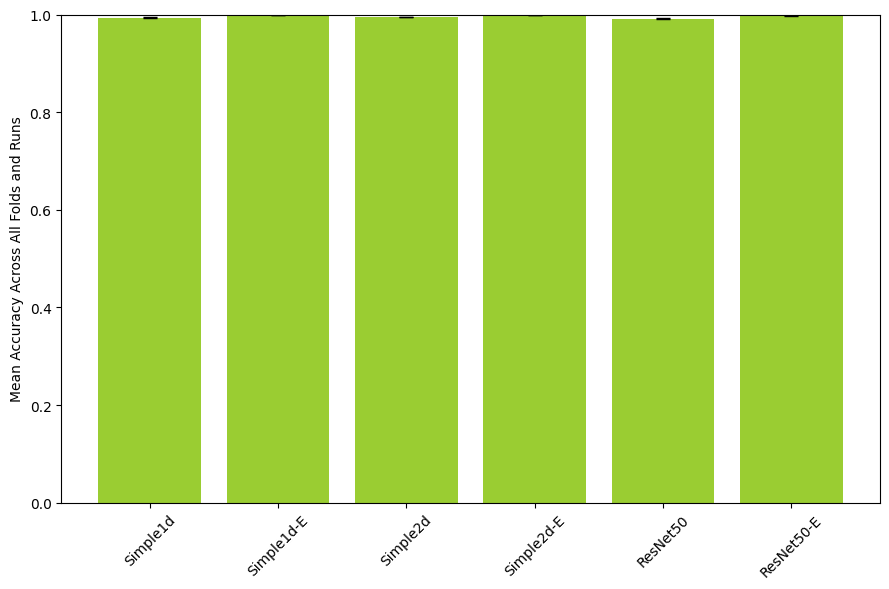

In [2]:
# Specify the directory containing the CSV files
directory = "./input/"  # Change this to your actual path
csv_files = glob.glob(os.path.join(directory, "KFold-*.csv"))
df_all = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

for target_feature in target_features:
    # Create a dictionary to store results for each model
    model_results = {}
    model_overall_results = {}

    # Get all unique architectures across all models
    all_architectures = set()

    for model_name in model_names:
        # Filter on model and target feature
        df = df_all[
            (df_all["model.name"] == model_name)
            & (df_all["target_feature"] == target_feature)
        ].reset_index(drop=True)

        # Filter out rows with Name "overall_metrics"
        df_filtered = df[df["Name"] != "overall_metrics"]

        # Group by the seed column and create a list of accuracies
        accuracy_lists = (
            df_filtered.groupby("validator.seed")["test_accuracy_chunk"]
            .apply(list)
            .tolist()
        )

        # Group by the seed column and create a list of dataset sizes
        fold_sample_counts = (
            df_filtered.groupby("validator.seed")["test_dataset_size"]
            .apply(list)
            .tolist()
        )

        # Get overall metrics
        overall_mean, overall_conf_95, _, _ = logo_cv_confidence_interval(
            all_run_fold_accuracies=accuracy_lists,
            fold_sample_counts=fold_sample_counts,
            confidence=0.95,
        )

        model_overall_results[model_name] = (overall_mean, overall_conf_95)

        # Get per-architecture metrics
        df_filtered = df[["Name", "test_accuracy_file", "test_loss", "train_loss"]]
        df_folds = df_filtered[df_filtered["Name"] != "overall_metrics"].rename(
            columns={"Name": "architecture"}
        )
        df_folds["architecture"] = df_folds["architecture"].str.removeprefix("fold_")

        df_agg = (
            df_folds.groupby("architecture")
            .agg({"test_accuracy_file": ["mean", "std"]})
            .reset_index()
        )

        # Store results and collect architectures
        model_results[model_name] = {
            arch: (mean, std)
            for arch, mean, std in zip(
                df_agg["architecture"],
                df_agg[("test_accuracy_file", "mean")],
                df_agg[("test_accuracy_file", "std")],
            )
        }
        all_architectures.update(df_agg["architecture"])

    # Calculate mean accuracy across models for each architecture
    arch_means = {}
    for arch in all_architectures:
        values = []
        for model in model_names:
            if arch in model_results[model]:
                values.append(model_results[model][arch][0])
        arch_means[arch] = np.mean(values)

    # Sort architectures by mean accuracy (descending)
    sorted_architectures = sorted(all_architectures, key=lambda x: x.lower())

    # Sort architectures by mean accuracy (descending)
    sorted_architectures = sorted(
        all_architectures, key=lambda x: arch_means[x], reverse=False
    )

    # Create bar chart aggregated by model
    plt.figure(figsize=(9, 6))
    model_means = []
    model_conf_95s = []

    for model in model_names:
        mean, conf_95 = model_overall_results[model]
        model_means.append(mean)
        model_conf_95s.append(conf_95)
        print(f"{model}: {mean:.3f} ± {conf_95:.3f}")

    xticks = [model.replace("Embedding", "-E") for model in model_names]

    bars = plt.bar(
        range(len(model_names)),
        model_means,
        yerr=model_conf_95s,
        capsize=5,
        color="yellowgreen",
    )
    plt.xticks(range(len(model_names)), xticks, rotation=45)
    plt.ylabel("Mean Accuracy Across All Folds and Runs")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(f"output/kfold-{target_feature.replace('_', '').lower()}-by-model.svg")